# Comparing my CAMB with CLASS

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
import camb
from scipy.interpolate import interp1d
import os
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.8 installed at /home/user/cosmo/CAMB-iDEDM/camb


In [2]:
def camb_get_pk_cls(h, omega_b, omega_cdm, As, ns, tau, xi_interaction, w):
    '''
    Returns CAMB CMB TT and matter power spectra, as well as the DE and CDM energy densities for a general cosmology, interacting or not
    '''
    cosmology = camb.set_params(# Background
                                H0 = 100*h, ombh2=omega_b*h**2, omch2=omega_cdm*h**2,
                                TCMB = 2.7255,
                                # Dark Energy
                                dark_energy_model='fluid', w = w,
                                xi_interaction = xi_interaction,
                                # Neutrinos
                                nnu=3.046, mnu = 0.058,
                                # Initial Power Spectrum
                                As = As, ns = ns, tau = tau,
                                YHe = 0.246, WantTransfer=True)
    cosmology.set_for_lmax(2500, lens_potential_accuracy=0)
    cosmology.set_matter_power(kmax=5)
    results = camb.get_results(cosmology)
    c_ells = results.get_cmb_power_spectra(cosmology)['total'][:,0]
    kh, z, pk_camb = results.get_matter_power_spectrum(minkh=1e-3, maxkh=1, npoints = 200)
    a = np.logspace(-8, 0, 200)
    z = 1/a - 1
    rhos = results.get_background_densities(a = a)
    return c_ells, kh, pk_camb, z, rhos['cdm']*(1+z)**4, rhos['de']*(1+z)**4 # REMEMBER that CAMB returns 8*pi*G*a**4*rho

In [3]:
def class_get_pk_cls(h, omega_b, omega_cdm, As, ns, tau, xi_interaction, w):
    '''
    Returns CLASS CMB TT and matter power spectra, as well as the DE and CDM energy densities for a general cosmology, interacting or not
    '''
    # create instance of the class "Class"
    cosmology = Class()
    # pass input parameters
    if xi_interaction == 0:
        cosmology.set({'Omega_b':omega_b,'Omega_cdm':omega_cdm,'h':h,'A_s':As,'n_s':ns,'tau_reio':tau})
    else:
        # Whenever using interacting DE-DM, must pass Omega_Lambda = 0, Omega_scf = 0, w0 = -0.999 and use_ppf = 'no'
        cosmology.set({'Omega_b':omega_b,'Omega_cdm':omega_cdm,'h':h,'A_s':As,'n_s':ns,'tau_reio':tau, 'Omega_Lambda':0, 'Omega_scf':0, 'delta_Q':xi_interaction, 'w0_fld':w, 'wa_fld':0, 'cs2_fld':1, 'use_ppf':'no', 'iDMDE_pert_type': 'DiValentino'})
    cosmology.set({'output':'tCl,lCl,mPk','lensing':'yes','P_k_max_h/Mpc':5.0, 'gauge':'synchronous'})
    # run class
    cosmology.compute()
    ells = np.arange(0,2501)
    c_ells = cosmology.lensed_cl(2500)['tt'] * ells * (ells + 1) / (2*np.pi)
    ks = np.logspace(-3, 0, 200) # in h/Mpc
    pk = np.zeros(200) # in (Mpc/h)^3
    for i,k in enumerate(ks):
        pk[i] = cosmology.pk(k*h, 0)*h**3
    bg = cosmology.get_background()
    if xi_interaction==0:
        return c_ells, ks, pk, bg['z'], 3*bg['(.)rho_cdm'], 3*bg['(.)rho_lambda'] # REMEMBER that CLASS returns 8*pi*G*rho/3
    else:
        return c_ells, ks, pk, bg['z'], 3*bg['(.)rho_cdm'], 3*bg['(.)rho_fld']

In [4]:
# Defining standard cosmological parameters
h = 0.67
omega_cdm = 0.27
omega_b = 0.049
As = 2.1e-9
ns = 0.96
tau = 0.09
xis = np.linspace(0, -0.9, 4)

/tmp/ipykernel_2610/967045026.py:12: RuntimeWarning: invalid value encountered in true_divide
  axs[1,0].semilogx((c_ells_camb[:2501]-c_ells_class)/c_ells_class, color=color)


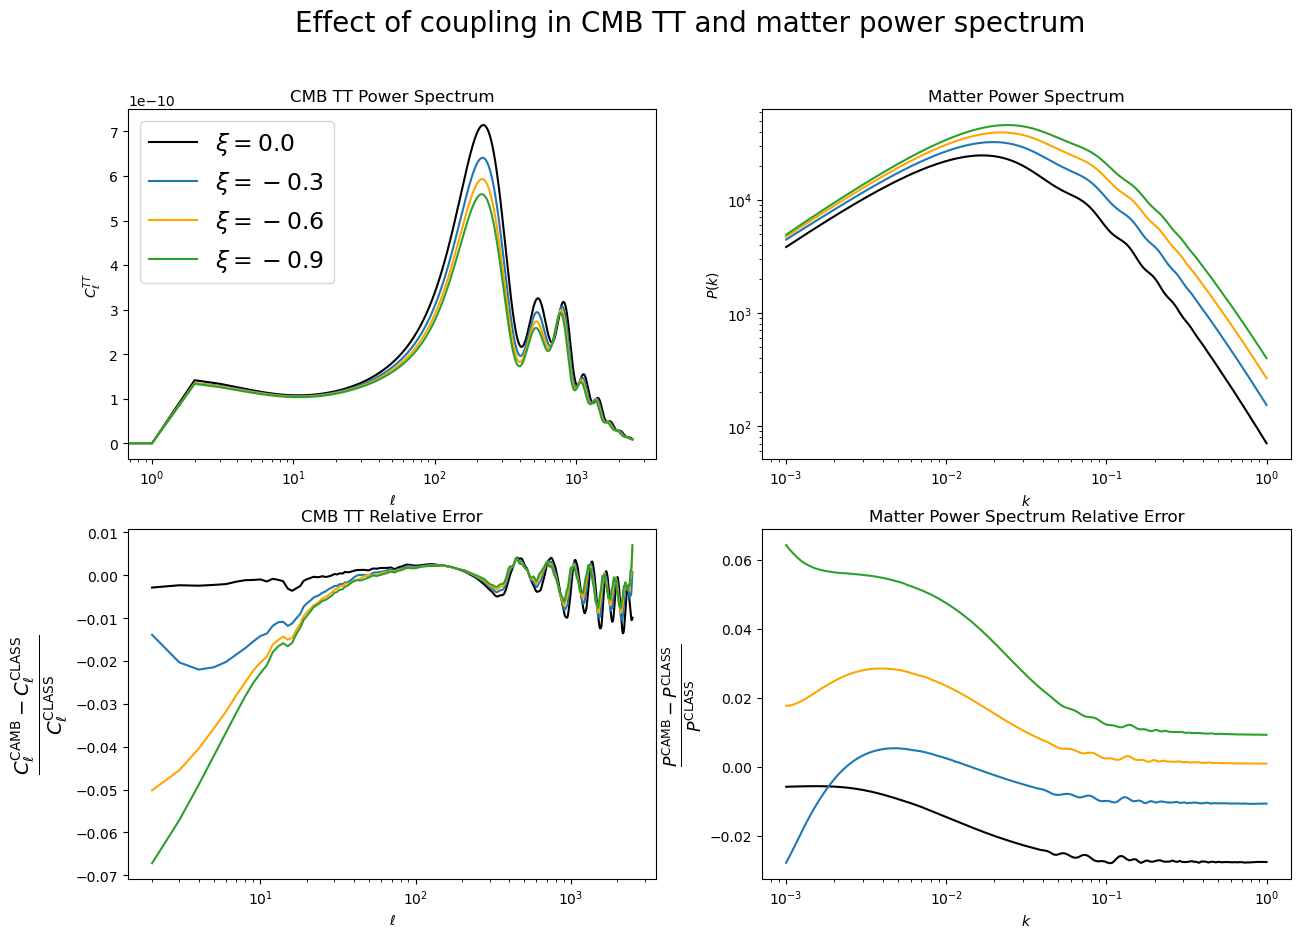

In [5]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
colors = ['black', 'tab:blue', 'orange', 'tab:green']
for color, xi in zip(colors, xis):
    if xi == 0:
        c_ells_class, ks_class, pk_class, _, _, _ = class_get_pk_cls(h, omega_b, omega_cdm, As, ns, tau, xi, -1)
        c_ells_camb, ks_camb, pk_camb, _, _, _ = camb_get_pk_cls(h, omega_b, omega_cdm, As, ns, tau, xi, -1)
    else:
        c_ells_class, ks_class, pk_class, _, _, _ = class_get_pk_cls(h, omega_b, omega_cdm, As, ns, tau, xi, -0.999)
        c_ells_camb, ks_camb, pk_camb, _, _, _ = camb_get_pk_cls(h, omega_b, omega_cdm, As, ns, tau, xi, -0.999)
    axs[0,0].semilogx(c_ells_class, color=color)
    axs[0,1].loglog(ks_class, pk_class, color=color)
    axs[1,0].semilogx((c_ells_camb[:2501]-c_ells_class)/c_ells_class, color=color)
    axs[1,1].semilogx(ks_class, (pk_camb[0]-pk_class)/pk_class, color=color)
axs[0,0].set_xlabel(r'$\ell$', fontsize=10)
axs[0,0].set_ylabel(r'$C_\ell^{TT}$', fontsize=10)
axs[0,0].set_title('CMB TT Power Spectrum')
axs[0,1].set_xlabel(r'$k$', fontsize=10)
axs[0,1].set_ylabel(r'$P(k)$', fontsize=10)
axs[0,1].set_title(r'Matter Power Spectrum')
axs[1,0].set_xlabel(r'$\ell$', fontsize=10)
axs[1,0].set_ylabel(r'$\frac{C_\ell^\mathrm{CAMB} - C_\ell^\mathrm{CLASS}}{C_\ell^\mathrm{CLASS}}$', fontsize=20)
axs[1,0].set_title(r'CMB TT Relative Error')
axs[1,1].set_xlabel(r'$k$', fontsize=10)
axs[1,1].set_ylabel(r'$\frac{P^\mathrm{CAMB} - P^\mathrm{CLASS}}{P^\mathrm{CLASS}}$', fontsize=18)
axs[1,1].set_title(r'Matter Power Spectrum Relative Error')
fig.suptitle('Effect of coupling in CMB TT and matter power spectrum', fontsize=20)
axs[0,0].legend([r'$\xi = {:.1f}$'.format(xi) for xi in xis], fontsize=17)
plt.savefig('Figures/coupling-exploration-class-differences.pdf', bbox_inches='tight')